# Scaling的目的
- Multi-scale learning，更robust、學習不同大小和距離的特徵
- 減少計算量

<img src="https://i.imgur.com/QngR3Qh.png" alt="drawing" width="300"/>

In [3]:
import torch.nn as nn
import os
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
import torch

In [4]:
def show_image_mask(*img_, split=False):
    plt.figure(figsize=(10,3))
    for i, img in enumerate(list(img_), 1):
#         print(np.shape(img))
        plt.subplot(1,len(img_),i)
    
            
        if type(img) == torch.Tensor:
            if len(img.shape)==4:
                if img.shape[1] == 3:
                    img =  img.flatten(0,1).permute(1,2,0).int().detach().numpy()
                else:
                    img =  img.flatten(0,2).int().detach().numpy()
            elif len(img.shape)==2:
                img = img.int().detach().numpy()
            
 
        
        img = img - img.min()
        if len(np.shape(img)) == 2 or np.shape(img)[-1] == 1:
            
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)
    plt.show()
    plt.close()

In [5]:
import os   
cmd = '''mkdir ./data
wget -q https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937454-1629951595/capsule.tar.xz -O data/MVtech-capsule.tar.xz
tar -Jxf data/MVtech-capsule.tar.xz --overwrite --directory ./data
'''
if not os.path.isdir('./data/capsule'):
    for i in cmd.split('\n'):
        os.system(i)

In [6]:
file = os.listdir(f'{os.getcwd()}/data/capsule/test/scratch/')
file = np.random.choice(file,size=1, replace=False)
file = [i.split('.')[0] for i in file]
file

['020']

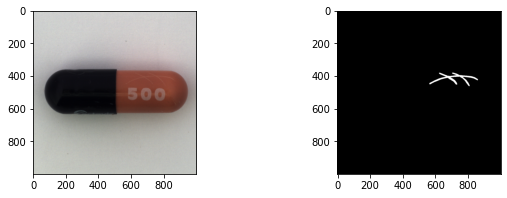

In [7]:
img_mask_list = []
for i in file:
    image = cv2.imread(f'{os.getcwd()}/data/capsule/test/scratch/{i}.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(f'{os.getcwd()}/data/capsule/ground_truth/scratch/{i}_mask.png', cv2.IMREAD_GRAYSCALE)
#     image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_AREA)
#     mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_AREA)
    img_mask_list.append((image, mask))
    show_image_mask(image, mask)

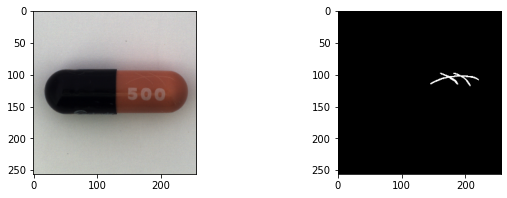

In [8]:
image = cv2.resize(image, (256,256))
mask = cv2.resize(mask, (256,256))
show_image_mask(image, mask)

## 上採樣
- 把影像的解析度放大
- resize到更大的解析度
- 最好是可以學的
- 不能學習的情況通常用通常用雙線性插值

In [9]:
# # to torch Tensor
# x = torch.Tensor(image)
# x = x.unsqueeze(0).permute(0,3,1,2)
# x.shape

In [10]:
x = torch.randn(1, 3, 28, 28)
# x = torch.Tensor(image)
# x = x.unsqueeze(0).permute(0,3,1,2)
print(x.shape)
x = nn.Upsample(scale_factor=2)(x)
x = nn.Conv2d(3, 9, kernel_size=3, padding='same')(x)
print(x.shape)

torch.Size([1, 3, 28, 28])
torch.Size([1, 9, 56, 56])


In [11]:
x = torch.randn(1, 3, 56, 56)
x, indice = nn.MaxPool2d(kernel_size=2, return_indices=True)(x)
print(x.shape)
x = nn.MaxUnpool2d(2)(x, indice)
x = nn.Conv2d(3, 9, kernel_size=3, padding='same')(x)
print(x.shape)

torch.Size([1, 3, 28, 28])
torch.Size([1, 9, 56, 56])


### Transposed Conv and UpsampleConv
<img src="https://i.imgur.com/eIIJxre.png" alt="drawing" width="300"/>
<img src="https://i.imgur.com/uLo7icF.png" alt="drawing" width="300"/>

Transposed Conv 
- 透過上面的操作做轉置卷積，feature-map上的數值會作為常數與kernel相乘，產出輸出的feature-map

UpsampleConv
- 先做上採樣(Upsample/ Unpooling)
- 然後作卷積(padding = same)
<!-- #### 替代方案 UpSampling(Unpooling)+Convolution -->


In [12]:
# ConvTranspose2d透過設定k=2, s=2, output_padding=0可以讓影像從28x28變成56x56
x = torch.randn(1, 3, 28, 28)
print(x.shape)
x = nn.ConvTranspose2d(3, 3, kernel_size=2, stride=2, output_padding=0)(x)
x = nn.Conv2d(3, 9, kernel_size=3, padding='same')(x)
print(x.shape)

torch.Size([1, 3, 28, 28])
torch.Size([1, 9, 56, 56])


## 下採樣
- Pooling
- Dilated Conv

### 1. Pooling

max pool，用max filter快速計算進行池化減少後續計算量，一般沒有特別考慮時可以使用的下採樣選擇

In [13]:
x = torch.randn(1, 3, 56, 56)
print(x.shape)
x= nn.MaxPool2d(kernel_size=2,)(x)
print(x.shape)

torch.Size([1, 3, 56, 56])
torch.Size([1, 3, 28, 28])


average pool，一種sum pooling，由於梯度會通過filter的每一個indice(max pooling的情況只會通過max indice)，所以DenseNet等論文特別採用他

In [14]:
x = torch.randn(1, 3, 56, 56)
print(x.shape)
x= nn.AvgPool2d(kernel_size=2,)(x)
print(x.shape)

torch.Size([1, 3, 56, 56])
torch.Size([1, 3, 28, 28])


### 2. PatchMerging 
> from swim-transform

In [15]:
class PatchMerging(nn.Module):
    def __init__(self, out_dim=0, input_resolution=None, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.out_dim = out_dim

    def forward(self, x):
        """
        x: B, H*W, C
        """
        B, C, H, W = x.shape
        L = H*W
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."
        x = x.view(B, C, H, W)
        
        x0 = x[:, :, 0::2, 0::2]  # B H/2 W/2 C
        x1 = x[:, :, 1::2, 0::2]  # B H/2 W/2 C
        x2 = x[:, :, 0::2, 1::2]  # B H/2 W/2 C
        x3 = x[:, :, 1::2, 1::2]  # B H/2 W/2 C
        
        
        x = torch.cat([x0, x1, x2, x3], 1)  # B H/2 W/2 4*C
        if self.out_dim<=0 or self.out_dim=='same':
            pass
        else:
            x = torch.nn.Conv2d(4*C, self.out_dim, 1)(x)

        return x

In [25]:
x = torch.randn(1, 2, 56, 56)
print(x.shape)
x = PatchMerging(out_dim=4)(x)
print(x.shape)

torch.Size([1, 2, 56, 56])
torch.Size([1, 4, 28, 28])


### 3. Dilated Conv. instead of pooling

In [19]:
x = torch.randn(1, 3, 56, 56)
x = nn.Conv2d(3, 9, kernel_size=3, stride=2, padding=1, dilation=(1,1))(x)
x.shape

torch.Size([1, 9, 28, 28])

In [20]:
x = torch.randn(1, 3, 56, 56)
x = nn.Conv2d(3, 9, kernel_size=3, stride=2, padding=3, dilation=(3,3))(x)
x.shape

torch.Size([1, 9, 28, 28])

In [21]:
x = torch.randn(1, 3, 56, 56)
x = nn.Conv2d(3, 9, kernel_size=3, stride=2, padding=5, dilation=(5,5))(x)
x.shape

torch.Size([1, 9, 28, 28])

In [22]:
dilated_rate = [1,2,3] 
dilatedConv = lambda rate:nn.Conv2d(3, 9, kernel_size=3, stride=2, padding=rate, dilation=(rate,rate))
for idx in range(3):
    x = torch.randn(1, 3, 56, 56)
    print(f'padding = {dilated_rate[idx]}, dilation=({dilated_rate[idx]},{dilated_rate[idx]})')
    x = dilatedConv(dilated_rate[idx%3])(x)
    print(x.shape)

padding = 1, dilation=(1,1)
torch.Size([1, 9, 28, 28])
padding = 2, dilation=(2,2)
torch.Size([1, 9, 28, 28])
padding = 3, dilation=(3,3)
torch.Size([1, 9, 28, 28])


In [23]:
dilated_rate = [1,2,3]
dilatedConv = lambda rate:nn.Conv2d(1, 1, kernel_size=3, stride=2, padding=rate, dilation=(rate,rate))
dilated_convBlock = nn.ModuleList([dilatedConv(i) for i in dilated_rate])

# x = torch.Tensor(mask)
# x = x[...,None,None].permute(2,3,0,1)
x = torch.randn(1, 1, 56, 56)
print(x.shape)
for i in dilated_convBlock:
    x = i(x)
    print(x.shape)
# x = dilated_convBlock(x)
# x.shape

torch.Size([1, 1, 56, 56])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 14, 14])
torch.Size([1, 1, 7, 7])
